<b><center><font size="5">BANK TRANSACTION ANALYSIS</font></center></b>  

In [1]:
#Importing libraries 
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns 

#set seaborn as default
sns.set()

In [2]:
# Read the file into a DataFrame: df
node = pd.read_csv('customer_node.csv')
region = pd.read_csv('customer_region.csv')
trans = pd.read_csv('customer_tran.csv')

In [3]:
node.head()

,customer_id,region_id,node_id,start_date,end_date
0,1,3,4,2020-01-02,2020-01-03
1,2,3,5,2020-01-03,2020-01-17
2,3,5,4,2020-01-27,2020-02-18
3,4,5,4,2020-01-07,2020-01-19
4,5,3,3,2020-01-15,2020-01-23


In [4]:
region.head()

,region_id,region_name
0,1,Australia
1,2,America
2,3,Africa
3,4,Asia
4,5,Europe


In [5]:
trans.head()

,customer_id,txn_date,txn_type,txn_amount
0,429,2020-01-21,deposit,82
1,155,2020-01-10,deposit,712
2,398,2020-01-01,deposit,196
3,255,2020-01-14,deposit,563
4,185,2020-01-29,deposit,626


<b> A. Customer Nodes Exploration </b>

1.	How many unique nodes are there on the Data Bank system?

In [6]:
print('Nodes-')
print(node['node_id'].drop_duplicates().sort_values().to_string(index=False))

Nodes-
1
2
3
4
5


2.	What is the number of nodes per region?

In [7]:
node[['node_id','region_id']].drop_duplicates().merge(region,on='region_id')\
.groupby('region_name',as_index=False)['node_id'].nunique()

,region_name,node_id
0,Africa,5
1,America,5
2,Asia,5
3,Australia,5
4,Europe,5


3.	How many customers are allocated to each region?

In [8]:
node[['region_id','customer_id']].drop_duplicates().merge(region,on='region_id')\
.groupby('region_name',as_index=False)['customer_id'].nunique()

,region_name,customer_id
0,Africa,102
1,America,105
2,Asia,95
3,Australia,110
4,Europe,88


4.	How many days on average are customers reallocated to a different node?

In [9]:
#Pandas to_datetime() method helps to convert string Date time into Python Date time object.
node['start_date'] = pd.to_datetime(node['start_date'])

#End date has invalid values. Hence replacing them with max available date in datetime function
node[node['end_date']=='9999-12-31']
node['end_date'].replace('9999-12-31','2262-04-11',inplace=True)
node['end_date'] = pd.to_datetime(node['end_date'])


In [10]:
print(np.mean((node[node['end_date'] < '2262-04-11']['end_date']-node[node['end_date'] < '2262-04-11']['start_date']).dt.days))

14.634


5.	What is the median, 80th and 95th percentile for this same reallocation days metric for each region?

In [11]:
node['avg_days'] = (node[node['end_date'] < '2262-04-11']['end_date']-node[node['end_date'] < '2262-04-11']['start_date'])\
.dt.days

df_15 = node.dropna().merge(region,on='region_id').groupby('region_name',as_index =False)\
.agg(med= ('avg_days','median'), per_95 = ('avg_days',lambda x :x.quantile(0.95)), \
     per_80 = ('avg_days',lambda x : x.quantile(0.8)))

df_15

,region_name,med,per_95,per_80
0,Africa,15.0,28.0,24.0
1,America,15.0,28.0,23.0
2,Asia,15.0,28.0,23.0
3,Australia,15.0,28.0,23.0
4,Europe,15.0,28.0,24.0


<b> B. Customer Transactions

1.	What is the unique count and total amount for each transaction type?

In [12]:
df_b1 = trans.drop_duplicates()
df_b1.groupby('txn_type',as_index = False).agg(unique_count = ('txn_amount','count'),total_amt= ('txn_amount','sum'))

,txn_type,unique_count,total_amt
0,deposit,2671,1359168
1,purchase,1617,806537
2,withdrawal,1580,793003


2.	What is the average total historical deposit counts and amounts for all customers?

In [13]:
df_b2 = df_b1[df_b1['txn_type']=='deposit'].groupby('customer_id',as_index = False)\
.agg(unique_count = ('txn_amount','count'),total_amt= ('txn_amount','sum'))

print(np.mean(df_b2['unique_count']),np.mean(df_b2['total_amt']))

5.342 2718.336


3.	For each month - how many Data Bank customers make more than 1 deposit and either 1 purchase or 1 withdrawal in a single month?

In [14]:
trans['txn_date'] = pd.to_datetime(trans['txn_date'])

df_31 = trans
df_31['Month'] = trans['txn_date'].dt.month

df_32= df_31.groupby(['customer_id','Month','txn_type'],as_index = False).size()\
.pivot(index=['customer_id','Month'],columns='txn_type',values='size' )
df_32.reset_index(inplace=True)

df_32[(df_32['deposit']>1) & ((df_32['purchase']==1)| (df_32['withdrawal']==1))]\
.groupby('Month')['customer_id'].nunique()

Month
1    115
2    108
3    113
4     50
Name: customer_id, dtype: int64

4.	What is the closing balance for each customer at the end of the month?

In [15]:
def balance_comp(data):
    data['balance'] =0

    for i in range(len(data)):
        if (i==0):
            data['balance'][i] = data['deposit'][i]-data['total_withdraw'][i]
        else:
            data['balance'][i] = data.loc[i-1,'balance']-data.loc[i,'total_withdraw']+data.loc[i,'deposit']
    
    return data

In [ ]:
df_41 = df_31.groupby(['customer_id','Month','txn_type'], as_index = False)['txn_amount'].sum()\
.pivot(index=['customer_id','Month'],columns='txn_type',values='txn_amount' )
df_41.reset_index(inplace=True)

df_41 = df_41.fillna(0)
df_41['total_withdraw'] = df_41['purchase']+df_41['withdrawal']

df_41 = df_41.sort_values(['customer_id','Month'])
cust_id = df_41['customer_id'].drop_duplicates()

data = df_41[df_41['customer_id'] == 1].reset_index()
final = balance_comp(data)

for i in range(2,501):
    data = df_41[df_41['customer_id'] == i].reset_index()
    final = final.append(balance_comp(data),ignore_index = True)
    


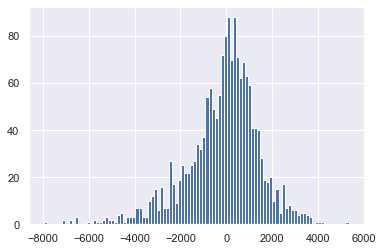

In [17]:
plt.hist(final['balance'],bins = 100)
plt.show()

5.	What is the percentage of customers who increase their closing balance by more than 5%?

In [18]:
min_month = final.groupby('customer_id', as_index = False)['Month'].min()\
            .merge(final[['customer_id','Month','balance']],on = ['customer_id','Month'])


max_month = final.groupby('customer_id', as_index = False)['Month'].max()\
            .merge(final[['customer_id','Month','balance']],on = ['customer_id','Month'])

df_51 = min_month.merge(max_month,on ='customer_id')
df_51['increase%']=((df_51['balance_y']-df_51['balance_x'])/df_51['balance_y'])*100
print('Percentage of customers who increase their closing balance by more than 5% :  ',
      (df_51[df_51['increase%']>5]['customer_id'].nunique())/(df_51['customer_id'].nunique())*100)

Percentage of customers who increase their closing balance by more than 5% :   83.2
